In [160]:
import pandas as pd
import numpy as np
import json
import pprint
import re
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
 
from sklearn.feature_selection import f_classif, f_regression, mutual_info_regression 
from sklearn.model_selection import KFold,cross_val_score, train_test_split
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression

pd.set_option('max_columns', 32)
VAL_SIZE   = 0.20
RANDOM_SEED = 42

## Data Preprocessing

In [61]:
# Загрузим тестовый датасет
test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

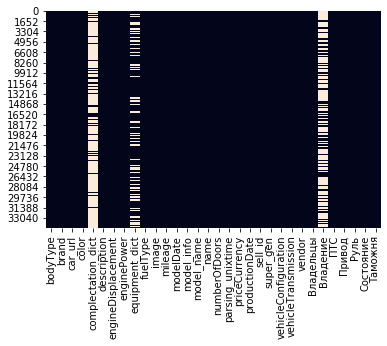

In [62]:
# Посмотрим на пропуски
sns.heatmap(test.isna(), cbar=False)

Почти все колонки заполнены, имеется много пропусков  в complectation_dict, Владение
6 колонок с числовыми значениями

In [63]:
# Выедем первый 5 строк тестового датасета
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [64]:
# Удалим колонки complectation_dict, vehicleConfiguration, name,image,priceCurrency, car_url, equipment_dict, Владение они дублирует equipment_dict и имеет очень мало значений 
test.drop(['complectation_dict', 'vehicleConfiguration', 'parsing_unixtime', 'name','image','priceCurrency', 'car_url', 'equipment_dict', 'Владение', 'super_gen', 'model_info', 'vendor'], axis = 1, inplace = True)

In [65]:
# Посмтрим на колонку "engineDisplacement"
test.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR'], dtype=object)

In [66]:
# Интересно какие значения в колонке "engineDisplacement" у электрокаров
test.query("fuelType == 'электро'")

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня
5241,внедорожник 5 дв.,AUDI,белый,Audi e-tron Prestige quattro от Moscow Tesla C...,LTR,408 N12,электро,885,2018,E_TRON,5,2019,1101083243,автоматическая,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен
7992,хэтчбек 5 дв.,BMW,синий,"Атомобиль из Германии,без пробега по РФ.\nНа г...",LTR,170 N12,электро,32000,2017,I3,5,2018,1101043134,автоматическая,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8252,хэтчбек 5 дв.,BMW,серый,"Пробег 54000 км, запас хода на зарядке 130 км+...",LTR,170 N12,электро,51000,2013,I3,5,2014,1101278018,автоматическая,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8350,хэтчбек 5 дв.,BMW,белый,"Автомобиль в наличии Москве , с ПТС , производ...",LTR,170 N12,электро,25000,2017,I3,5,2018,1100271628,автоматическая,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8684,хэтчбек 5 дв.,BMW,чёрный,BMW I 3 REX\nфевраль 2017 года выпуска.\nПриоб...,LTR,170 N12,электро,58500,2013,I3,5,2017,1101174554,автоматическая,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8722,хэтчбек 5 дв.,BMW,голубой,\nПрибыло из Америки в августе 2020 года. Полн...,LTR,170 N12,электро,28800,2013,I3,5,2017,1100097316,автоматическая,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен
8917,хэтчбек 5 дв.,BMW,бежевый,-Состояние нового автомобиля .\n-Carfax вся ис...,LTR,170 N12,электро,39000,2013,I3,5,2017,1100871574,автоматическая,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен
10817,хэтчбек 5 дв.,BMW,серый,Продаю BMW I3 +REX .\n\nПолноценный электромоб...,LTR,170 N12,электро,50359,2013,I3,5,2016,1101266443,автоматическая,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен
10936,хэтчбек 5 дв.,BMW,чёрный,Автомобиль BMW i3 (полностью электрический )за...,LTR,170 N12,электро,78000,2013,I3,5,2016,1099673346,автоматическая,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен
11043,хэтчбек 5 дв.,BMW,серый,Состояние нового автомобиля . \nФото ИМЕННО ЭТ...,LTR,170 N12,электро,20000,2013,I3,5,2017,1099376120,автоматическая,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен


преобразуем позже вместе с тренировочным датасетом

In [67]:
#В колонке engineDisplacement оставим только численное значение
pattern = re.compile('[0-9]+\W*[0-9*]')
test.engineDisplacement = test.engineDisplacement.apply(lambda x: float(pattern.findall(x)[0])if len(x)>4 else 0)

In [68]:
# Посмтрим на колонку "enginePower"
test.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [69]:
# В колонке enginePower оставим только численные значения
test.enginePower = test.enginePower.apply(lambda x: float(x[:-4]))

In [70]:
# Загрузим данные парсинга
train_june = pd.read_csv('train1.csv')
train_oct = pd.read_csv('train_oct.csv')
train = train_june.append(train_oct, sort = False).reset_index(drop = True) 


C:\IT\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [71]:
# Проверим наличие дубликатов
sum(train.duplicated())

12613

In [72]:
# Удалим дубликаты
train.drop_duplicates(inplace=True)

In [73]:
# Выведем тренировочный датасетa
train

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,sell_id
0,седан,FIAT,синий,"1 Владлелец, оригинал ПТС, 2 ключа. Технически...",1.4,77.0,GASOLINE,40600.0,2005.0,ALBEA,4,2011.0,механическая,1,Оригинал,передний,Левый,Не требует ремонта,9 лет и 9 месяцев,320000.0,1.103762e+09
1,седан,FIAT,чёрный,Возможность приобрести АВТОМОБИЛЬ в КРЕДИТ со ...,1.4,77.0,GASOLINE,126000.0,2005.0,ALBEA,4,2009.0,механическая,3,Оригинал,передний,Левый,Не требует ремонта,Растаможен,249000.0,1.103481e+09
2,седан,FIAT,серый,Машиной пользовались редко. Последний год вооб...,1.4,77.0,GASOLINE,32082.0,2005.0,ALBEA,4,2008.0,механическая,1,Оригинал,передний,Левый,Не требует ремонта,12 лет и 6 месяцев,300000.0,1.103996e+09
3,седан,FIAT,синий,Более 150 автомобилей с пробегом в наличии!- в...,1.4,77.0,GASOLINE,136917.0,2005.0,ALBEA,4,2007.0,механическая,3,Дубликат,передний,Левый,Не требует ремонта,Растаможен,200000.0,1.103668e+09
4,седан,FIAT,красный,Продам фиатик.сделано большое ТО.Поменяно масл...,1.4,77.0,GASOLINE,101000.0,2005.0,ALBEA,4,2008.0,механическая,2,Оригинал,передний,Левый,Не требует ремонта,13 лет и 5 месяцев,250000.0,1.103995e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96227,фургон,VOLKSWAGEN,белый,Продам 2 транспортера Т3Один на ходуВторой нет,1.6,70.0,DIESEL,205000.0,1979.0,TRANSPORTER,4,1987.0,механическая,1,Оригинал,задний,Левый,Не требует ремонта,Растаможен,145000.0,1.105417e+09
96228,фургон,VOLKSWAGEN,белый,Машина в нормальном состоянии для своих лет.Вк...,2.1,95.0,GASOLINE,350000.0,1979.0,TRANSPORTER,4,1979.0,механическая,2,Оригинал,полный,Левый,Не требует ремонта,Растаможен,600000.0,1.103330e+09
96229,фургон,VOLKSWAGEN,белый,"Последний год выпуска авто, В России с 2001 го...",1.7,57.0,DIESEL,57445.0,1979.0,TRANSPORTER,4,1991.0,механическая,4,Оригинал,задний,Левый,Не требует ремонта,Растаможен,260000.0,1.105266e+09
96230,фургон,VOLKSWAGEN,жёлтый,из нового кпп 4х ступка длинная(маркировку не ...,1.6,50.0,DIESEL,34000.0,1979.0,TRANSPORTER,5,1987.0,механическая,3,Оригинал,задний,Левый,Не требует ремонта,Растаможен,130000.0,1.104617e+09


In [74]:
# Приведем название колонок к удобному виду
train.columns = list(map(str.lower,train.columns))
test.columns = list(map(str.lower,test.columns))

In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83619 entries, 0 to 96231
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodytype             83619 non-null  object 
 1   brand                83619 non-null  object 
 2   color                83619 non-null  object 
 3   description          83484 non-null  object 
 4   enginedisplacement   83619 non-null  float64
 5   enginepower          83619 non-null  float64
 6   fueltype             83619 non-null  object 
 7   mileage              83619 non-null  float64
 8   modeldate            83619 non-null  float64
 9   model_name           83619 non-null  object 
 10  numberofdoors        83619 non-null  int64  
 11  productiondate       83619 non-null  float64
 12  vehicletransmission  83619 non-null  object 
 13  владельцы            83619 non-null  object 
 14  птс                  83619 non-null  object 
 15  привод               83619 non-null 

Тренировочный датасет заполнен
имеется 8 колонок с числовыми данными

In [76]:
columns = ['bodytype', 'brand', 'color', 'enginedisplacement',
       'enginepower', 'fueltype', 'mileage', 'modeldate', 'model_name',
       'numberofdoors', 'productiondate', 'vehicletransmission', 'владельцы',
       'птс', 'привод', 'руль', 'sell_id']
df_train = train[columns]
df_train['price'] = train['price']
df_test = test[columns]
df_test['price'] = pd.Series()

C:\IT\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\IT\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\IT\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\IT\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\IT\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
df

,bodytype,brand,color,enginedisplacement,enginepower,fueltype,mileage,modeldate,model_name,numberofdoors,productiondate,vehicletransmission,владельцы,птс,привод,руль,sell_id,price,sample
0,лифтбек,SKODA,синий,1.2,105.0,бензин,74000.0,2013.0,OCTAVIA,5,2014.0,роботизированная,3 или более,Оригинал,передний,Левый,1.100575e+09,NaN,0
1,лифтбек,SKODA,чёрный,1.6,110.0,бензин,60563.0,2017.0,OCTAVIA,5,2017.0,механическая,1 владелец,Оригинал,передний,Левый,1.100549e+09,NaN,0
2,лифтбек,SKODA,серый,1.8,152.0,бензин,88000.0,2013.0,SUPERB,5,2014.0,роботизированная,1 владелец,Оригинал,передний,Левый,1.100658e+09,NaN,0
3,лифтбек,SKODA,коричневый,1.6,110.0,бензин,95000.0,2013.0,OCTAVIA,5,2014.0,автоматическая,1 владелец,Оригинал,передний,Левый,1.100937e+09,NaN,0
4,лифтбек,SKODA,белый,1.8,152.0,бензин,58536.0,2008.0,OCTAVIA,5,2012.0,автоматическая,1 владелец,Оригинал,передний,Левый,1.101038e+09,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118300,фургон,VOLKSWAGEN,белый,1.6,70.0,DIESEL,205000.0,1979.0,TRANSPORTER,4,1987.0,механическая,1,Оригинал,задний,Левый,1.105417e+09,145000.0,1
118301,фургон,VOLKSWAGEN,белый,2.1,95.0,GASOLINE,350000.0,1979.0,TRANSPORTER,4,1979.0,механическая,2,Оригинал,полный,Левый,1.103330e+09,600000.0,1
118302,фургон,VOLKSWAGEN,белый,1.7,57.0,DIESEL,57445.0,1979.0,TRANSPORTER,4,1991.0,механическая,4,Оригинал,задний,Левый,1.105266e+09,260000.0,1
118303,фургон,VOLKSWAGEN,жёлтый,1.6,50.0,DIESEL,34000.0,1979.0,TRANSPORTER,5,1987.0,механическая,3,Оригинал,задний,Левый,1.104617e+09,130000.0,1


In [79]:
# Посмтрим на колонку "color"
train.color.value_counts()

чёрный         21643
белый          13903
серый          11287
серебристый     9426
синий           8652
красный         5020
зелёный         3600
коричневый      3237
бежевый         2015
голубой         1305
пурпурный        840
жёлтый           724
фиолетовый       709
золотистый       693
оранжевый        533
розовый           32
Name: color, dtype: int64

Имеем 5 топовых цватов с большим количественным отрывом

In [80]:
#Посмотрим на столбец "владельцы"
df.владельцы.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', '1', '3', '2',
       '4', 'О', 4, 1, 2, 3], dtype=object)

In [81]:
# Преобразуем столбец в коррктный вид
владельцы_dict = {'О':1,'2':2,'1':1, '3':3, '4':4, '3 или более':4, '1\xa0владелец':1, '2\xa0владельца':2}
df['владельцы'].replace(to_replace=владельцы_dict, inplace=True)

In [82]:
#Посмотрим на столбец "fueltype"
df.fueltype.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ', 'GASOLINE',
       'DIESEL', 'LPG', 'HYBRID', 'ELECTRO'], dtype=object)

У нас присутствуют названия на английском и руском

In [83]:
# Преобразуем столбец в коррктный вид
fueltype_dict = {'бензин':'GASOLINE','дизель':'DIESEL', 'гибрид':'HYBRID', 'электро':'ELECTRO', 'газ':'LPG'}
df['fueltype'].replace(to_replace=fueltype_dict, inplace=True)

In [84]:
# Посмотрим на столбец "птс"
df.птс.value_counts()

Оригинал    101098
Дубликат     17206
Name: птс, dtype: int64

In [85]:
# Внем есть пропуски заменим их на наиболее частое значение
df['птс'] = df['птс'].fillna('Оригинал')

In [86]:
# Посмотрим на столбец "numberofdoors"
df.numberofdoors.value_counts()

5    68978
4    44415
2     2468
3     2441
1        2
0        1
Name: numberofdoors, dtype: int64

Автомобили с4 и 5 дверьми преобладают

In [87]:
df[df.numberofdoors == 0]

,bodytype,brand,color,enginedisplacement,enginepower,fueltype,mileage,modeldate,model_name,numberofdoors,productiondate,vehicletransmission,владельцы,птс,привод,руль,sell_id,price,sample
16944,кабриолет,MERCEDES,белый,5.3,32.0,GASOLINE,48000.0,1904.0,SIMPLEX,0,1904.0,механическая,1,Оригинал,задний,Правый,1.093802e+09,NaN,0


Это раритетный автомобиль, будет сложно его оценить

In [88]:
# В столбце 'enginedisplacement' для автомобилей с электрическим двигателем преобразуем значение в 0
df.enginedisplacement = df.apply(lambda row: row.enginedisplacement if row.fueltype != "ELECTRO" else 0, axis = 1)
df.enginedisplacement = df.enginedisplacement.apply(lambda x: x if x < 15 else df.enginedisplacement.mean())

In [89]:
# По данным автостата цена на автомобили за последний год увеличилась на 20%
df.price = df.price.apply(lambda x: x * 0.88)

## EDA

In [90]:
#Посморим на объединенные данные
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118305 entries, 0 to 118304
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodytype             118305 non-null  object 
 1   brand                118305 non-null  object 
 2   color                118305 non-null  object 
 3   enginedisplacement   118305 non-null  float64
 4   enginepower          118305 non-null  float64
 5   fueltype             118305 non-null  object 
 6   mileage              118305 non-null  float64
 7   modeldate            118305 non-null  float64
 8   model_name           118305 non-null  object 
 9   numberofdoors        118305 non-null  int64  
 10  productiondate       118305 non-null  float64
 11  vehicletransmission  118305 non-null  object 
 12  владельцы            118305 non-null  int64  
 13  птс                  118305 non-null  object 
 14  привод               118305 non-null  object 
 15  руль             

In [91]:
df.nunique()

bodytype                   26
brand                     108
color                      16
enginedisplacement         72
enginepower               433
fueltype                    5
mileage                 35557
modeldate                  80
model_name               1252
numberofdoors               6
productiondate             81
vehicletransmission         4
владельцы                   4
птс                         2
привод                      3
руль                        2
sell_id                112445
price                    6082
sample                      2
dtype: int64

In [92]:
#бинарныe переменные
bin_cols = ['птс', 'руль'] 
#категориальные переменные
cat_cols = ['bodytype', 'владельцы', 'brand', 'color', 'numberofdoors',  'fueltype', 'model_name',  'vehicletransmission', 'привод']
#числовые переменные
num_cols = ['mileage','enginepower','enginedisplacement','modeldate', 'productiondate']

### analysis of numerical features:

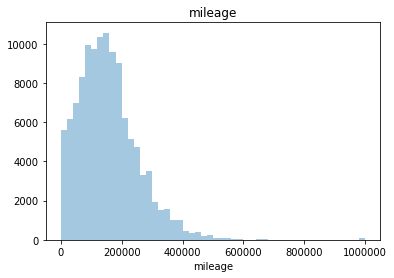

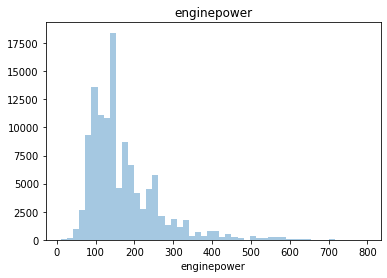

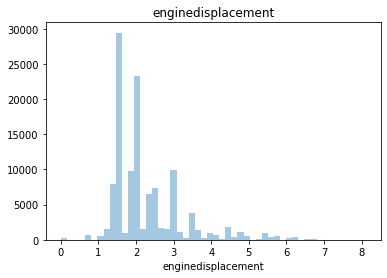

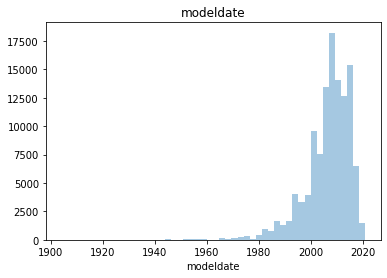

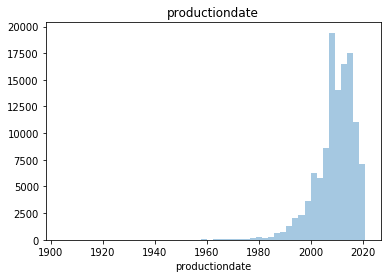

In [93]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

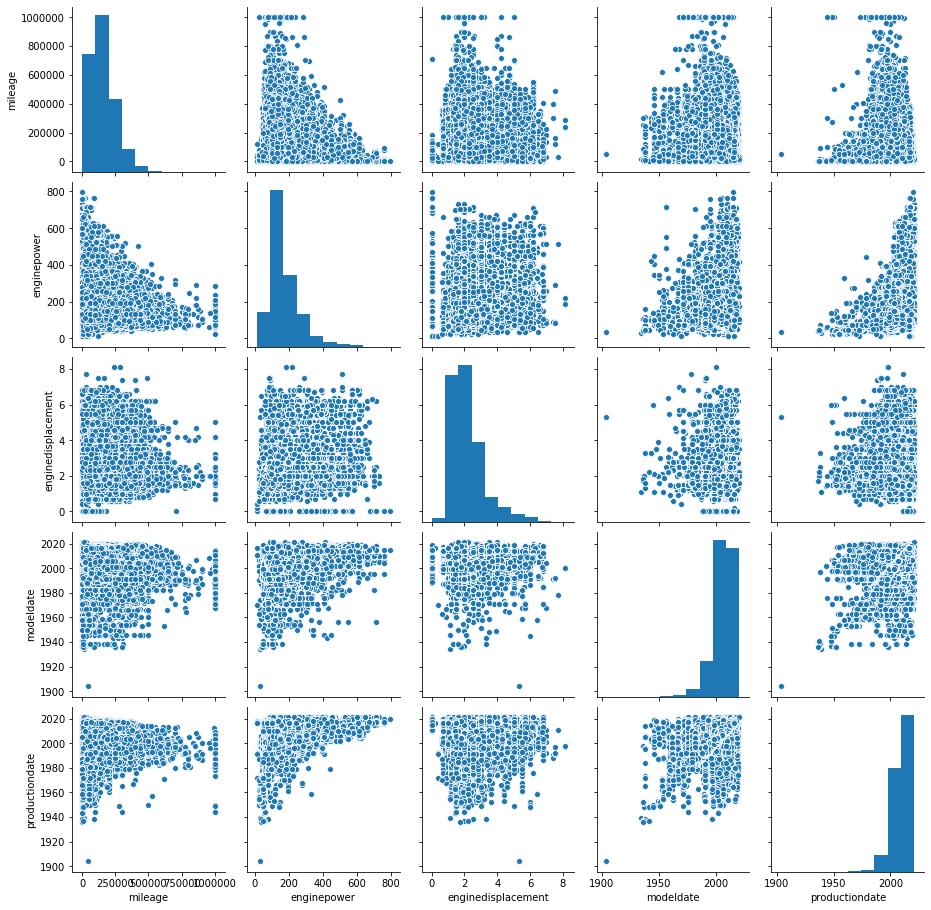

In [94]:
sns.pairplot(df[num_cols])

- Как мы видим из графиков числовые признаки не имеют нормального распределения, они имеют сдвиг влево или право.
- Столбцы "modeldate"  и "productiondate" имеют большую корреляцию.

In [95]:
df.query('sample == 1')[num_cols].describe()

,mileage,enginepower,enginedisplacement,modeldate,productiondate
count,83619.000000,83619.000000,83619.000000,83619.000000,83619.000000
mean,155090.709707,164.577309,2.197847,2006.172843,2009.170296
std,99097.389291,90.900904,0.946151,9.331883,7.913472
min,1.000000,11.000000,0.000000,1936.000000,1937.000000
25%,84000.000000,105.000000,1.600000,2002.000000,2006.000000
50%,143000.000000,141.000000,2.000000,2008.000000,2011.000000
75%,207000.000000,190.000000,2.500000,2013.000000,2014.000000
max,1000000.000000,795.000000,8.100000,2021.000000,2021.000000


In [96]:
df.query('sample == 0')[num_cols].describe()

,mileage,enginepower,enginedisplacement,modeldate,productiondate
count,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000
mean,162009.767889,188.194142,2.402255,2007.074728,2009.264602
std,100676.559489,89.087035,0.964484,7.415894,7.047661
min,1.000000,30.000000,0.000000,1904.000000,1904.000000
25%,91153.500000,125.000000,1.800000,2004.000000,2006.000000
50%,149779.500000,169.000000,2.000000,2008.000000,2011.000000
75%,215000.000000,233.000000,3.000000,2012.000000,2014.000000
max,1000000.000000,639.000000,6.600000,2020.000000,2020.000000


- Числовые признаки находятся в разных диапазонах, нам необходимо будеть нормалтзовать их перед ML.
- А признаки с длиннным хвостом прологарифмировать.
- тестовый и тренировочный датасеты не имеют больших расхождений по значениям

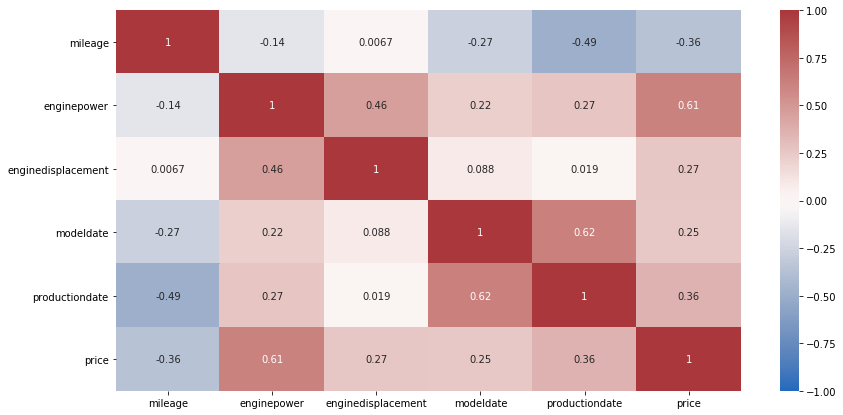

In [97]:
plt.figure(figsize=(14, 7));
sns.heatmap(df.query("sample == 1")[num_cols + ['price']].corr(), vmin=-1, vmax=1, annot=True, cmap='vlag');

- Ни один из признаков не имеет высокой корреляции, это хорошо, оставляем их все.

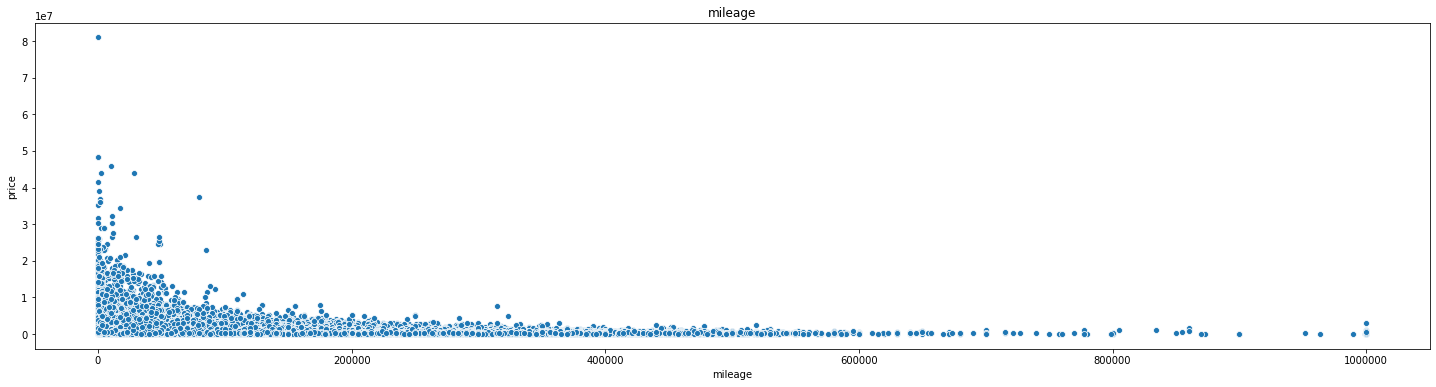

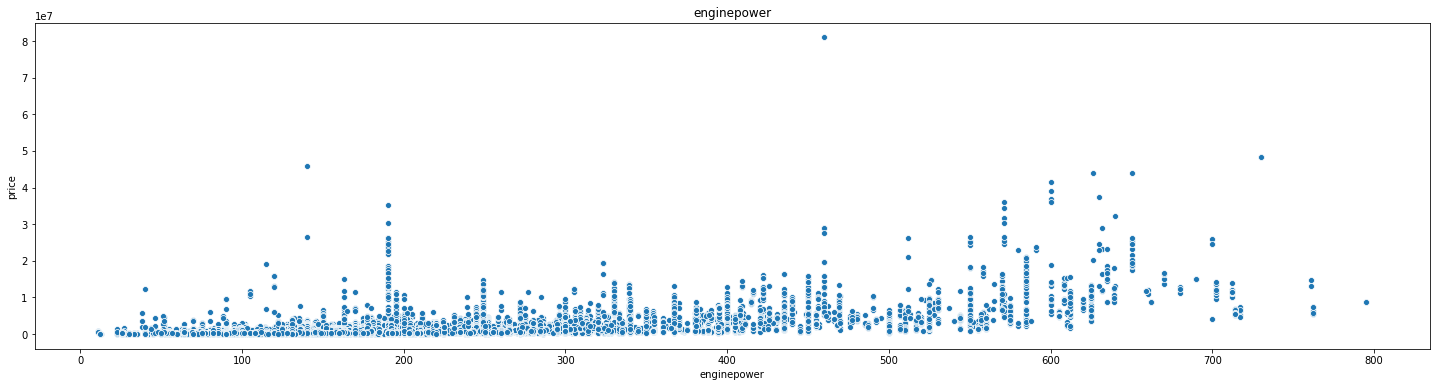

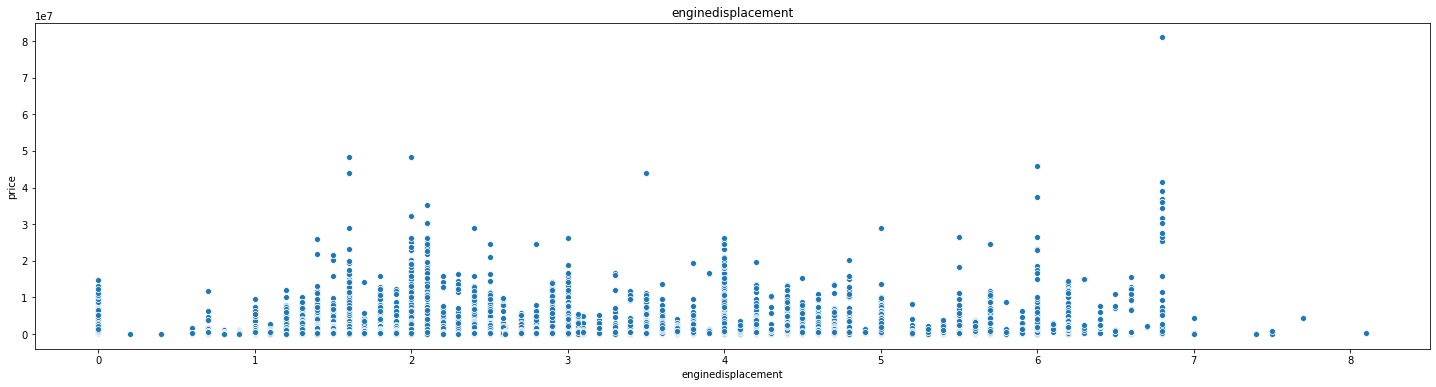

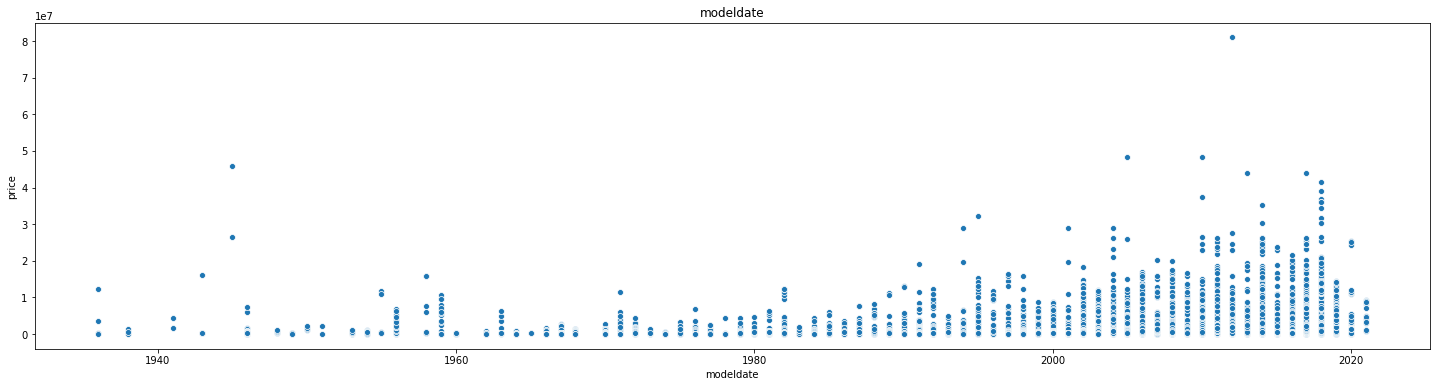

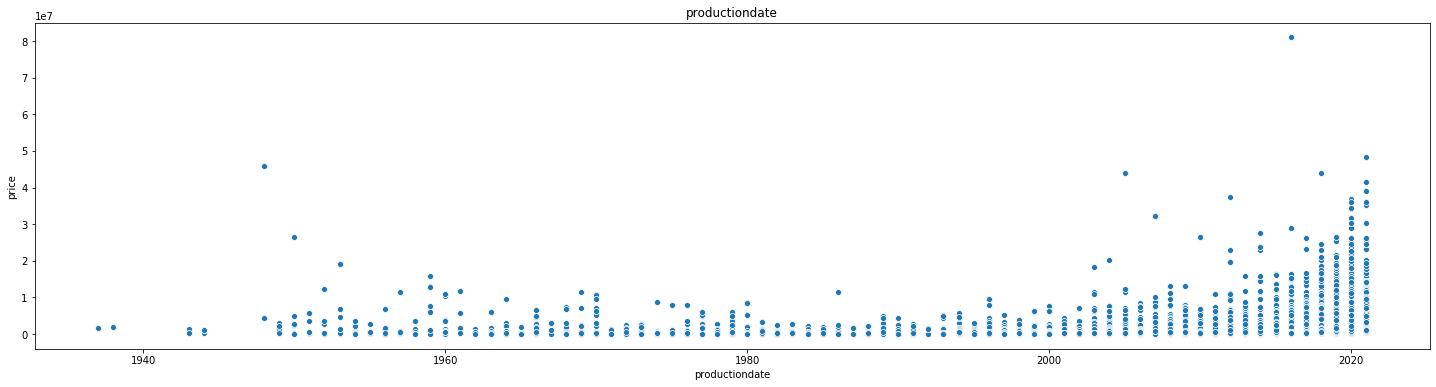

In [98]:
for i in num_cols:
    plt.figure(figsize=(25, 6))
    sns.scatterplot(data=df.query("sample == 1"), x=i, y="price")
    plt.title(i)
    plt.show()

- Признак "millage" имеет длинный правый хвост 
- Признак "productiondate" имеет ожидаемое увеличение цены за последние года.

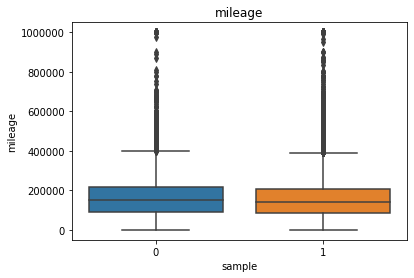

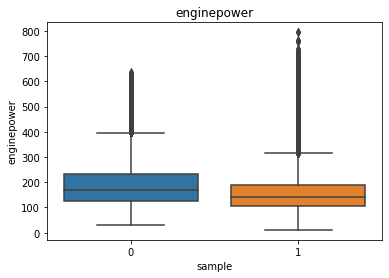

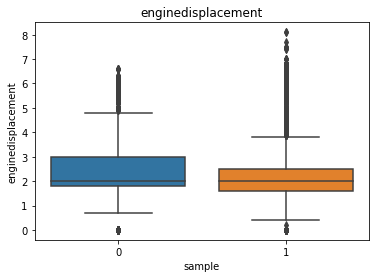

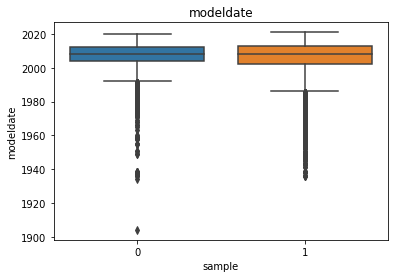

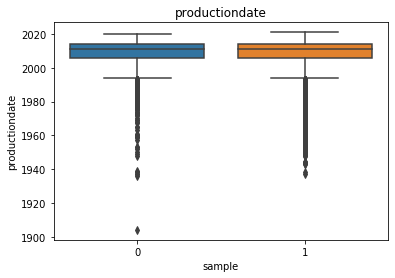

In [99]:
for i in num_cols:
    plt.figure()
    sns.boxplot(x = 'sample', y = i, data = df)
    plt.title(i)
    plt.show()

Распределение значений числовых признаков между тестовой и тренировочной выборками виглядит одинаково.

### analysis of categorical features:

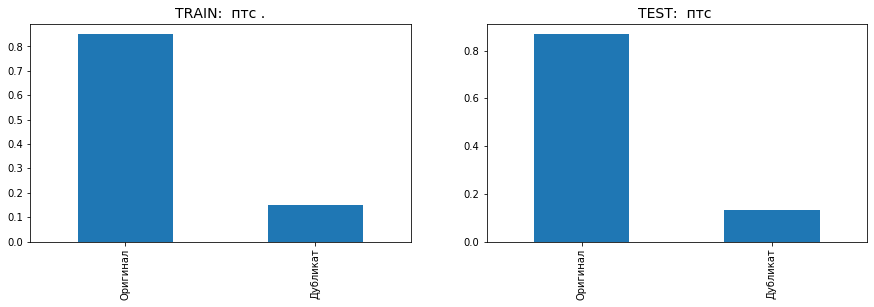

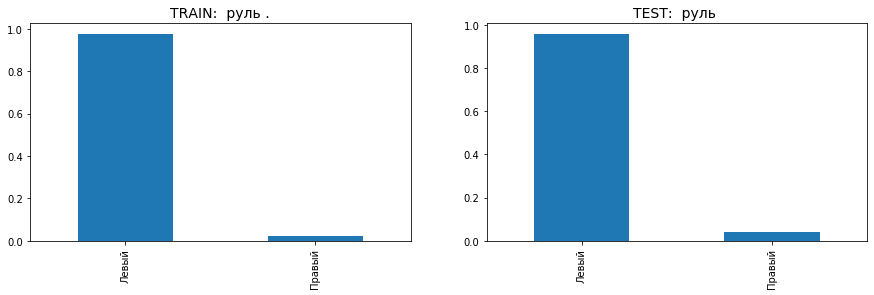

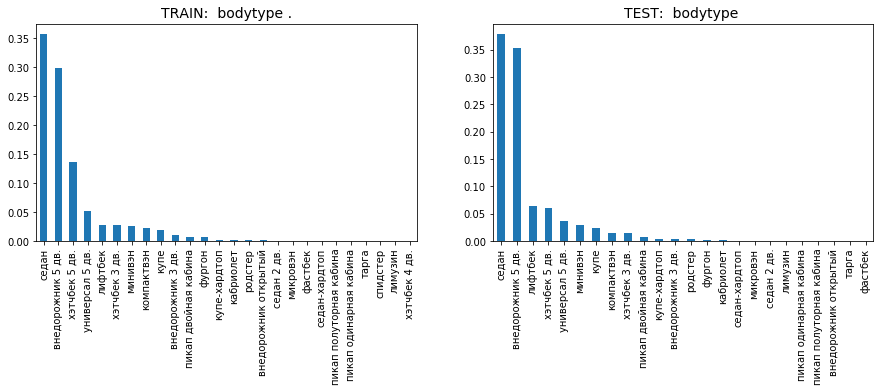

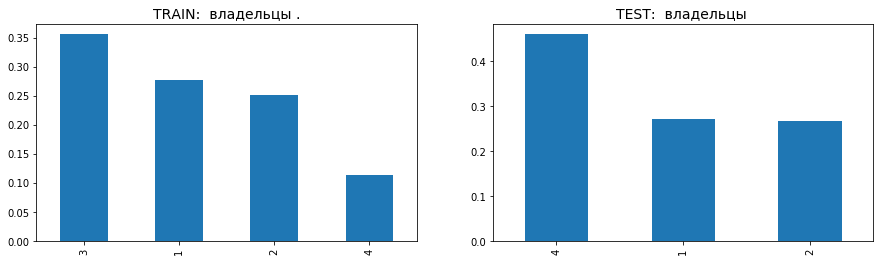

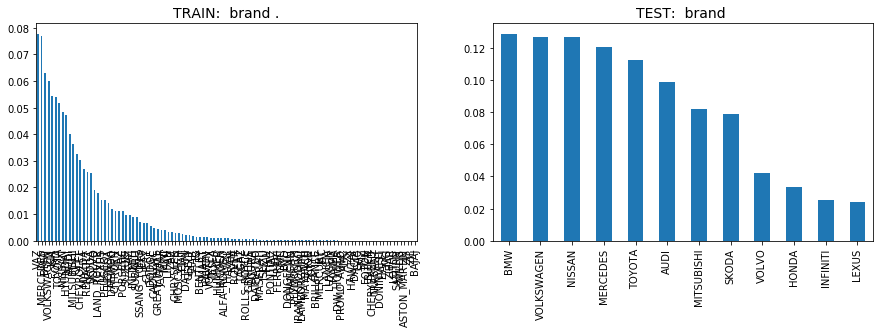

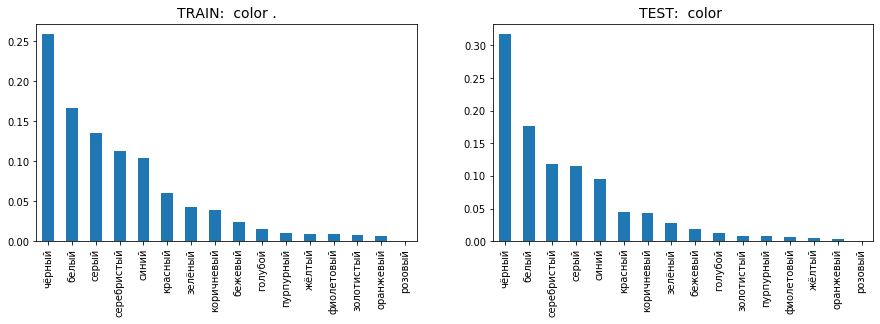

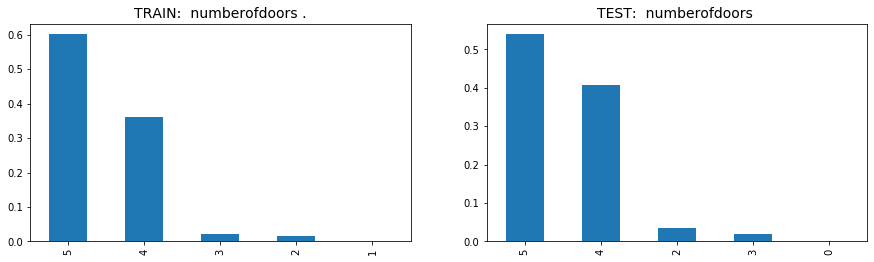

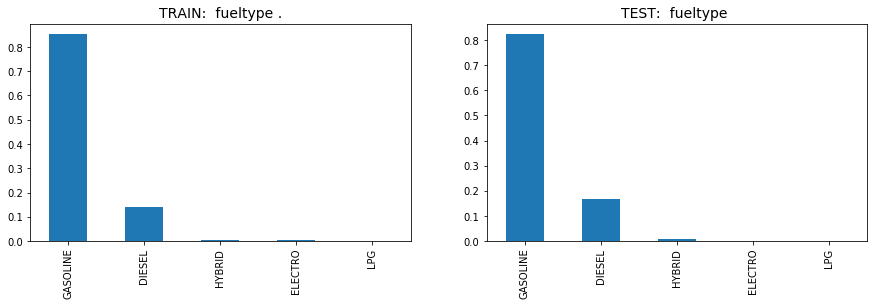

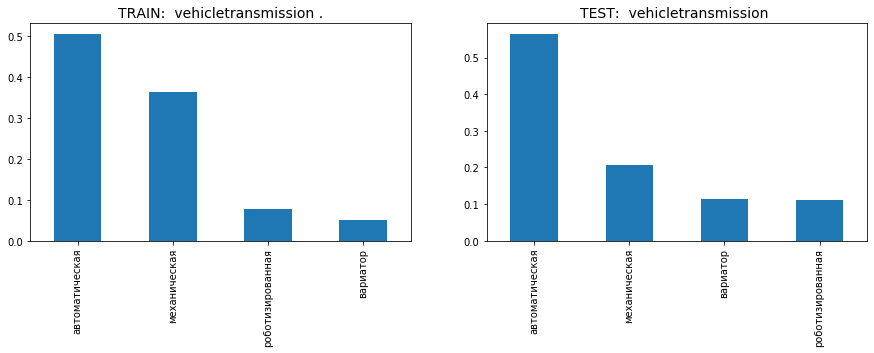

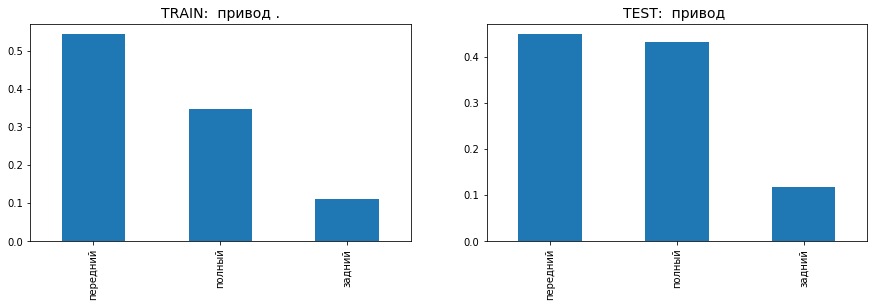

In [100]:
# Посмотрим на распределение категориальных признаков между train и test выборками
for col in bin_cols + cat_cols:
    if col not in ['model_name']: 
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2, nrows=1)
        ax[0].set_title(f'TRAIN:  {col} .', fontdict={'fontsize': 14})
        df.query('sample == 1')[col].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
        ax[1].set_title(f'TEST:  {col} ', fontdict={'fontsize': 14})
        df.query('sample == 0')[col].value_counts(normalize=True).plot(kind='bar', ax=ax[1])
        print('\n')
        plt.show()

- Значения в столбцах train и test относительно сбалансированы, кроме столбца "brand".
- Значения в столбцах внутри train и test наоборот имеют большой дисбаланс.

## Feature engineering

In [101]:
df.columns

Index(['bodytype', 'brand', 'color', 'enginedisplacement', 'enginepower',
       'fueltype', 'mileage', 'modeldate', 'model_name', 'numberofdoors',
       'productiondate', 'vehicletransmission', 'владельцы', 'птс', 'привод',
       'руль', 'sell_id', 'price', 'sample'],
      dtype='object')

In [102]:
# Вводим новый признак - разницу между годом выпуска автомобиля и модели
df['model_old'] = (df.productiondate - df.modeldate)

# Вводим новый признак - возраст машины
df['car_old'] = (2021 - df.productiondate)

In [103]:
err_list= df[df.model_old<0].index
df.loc[err_list, 'modeldate'] = df.loc[err_list].productiondate.values-1
df['model_old'] = (df.productiondate - df.modeldate)

In [104]:
# Электро кары имеют специфицеский объём двигателя, пробег, также они появились недавно пометим их датасете

In [ ]:
# Электро кары имеют специфицеский объём двигателя, пробег, также они появились недавно пометим их датасете
# Добавим признаки на основе этапов Predprocessing data и EDA
df['is_electro'] = df.fueltype.apply(lambda x: 1 if x == "ELECTRO" else 0)
df['older_3y'] = df.productiondate.apply(lambda x: 1 if x < 2021 - 3 else 0)
df['older_5y'] = df.productiondate.apply(lambda x: 1 if x < 2021 - 5 else 0)
df['rarity'] = df.productiondate.apply(lambda x: 1 if x < 1960 else 0)
df['mileage_per_year'] = df.productiondate / df.mileage
df['mileage_per_year'].replace([np.inf, -np.inf], 0, inplace=True)
df['top2_bodytype'] = df.bodytype.apply(lambda x: 1 if x in ['внедорожник', 'седан'] else 0)
df['top2_door_numb'] = df.numberofdoors.apply(lambda x: 1 if x in [4, 5] else 0)
same_brand_list = df.query('sample == 0').brand.unique()
df['same_brand'] = df.brand.apply(lambda x: 1 if x in same_brand_list else 0)

In [109]:
bin_cols.extend(['is_electro', 'same_brand', 'older_3y', 'older_5y', 'rarity', 'top2_bodytype', 'top2_door_numb'])
num_cols.extend([ 'model_old', 'car_old', 'mileage_per_year'])

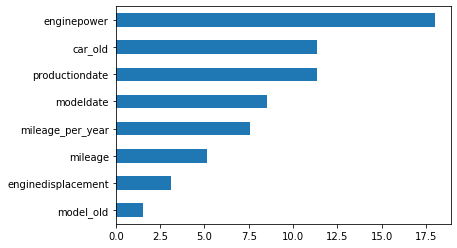

In [110]:
# Посмотрим на важность числовых признаков
imp_num = Series(f_classif(df.query('sample == 1')[num_cols], df.query('sample == 1')['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='The importance of the numerical columns.')

In [132]:
# Прологарифмируем числовые признаки, так как у всех имеем много 0 значений и длинный правый хвост. 
#df['mileage'] = np.log(df['mileage']+1)
df['enginepower'] = np.log(df['enginepower']+1)

In [133]:
# Для бинарных признаков пробовал использовать OneHotEncoding метрика получается хуже 
# Поэтому для категориальных и бинарных признаков  будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in cat_cols + bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

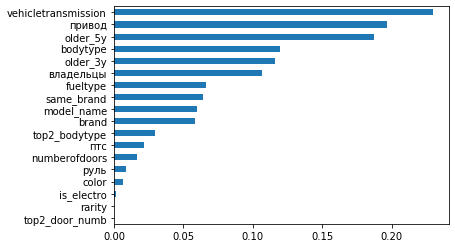

In [135]:
# Посмотрим на важность категориальных признаков
imp_cat = Series(mutual_info_regression(df.query('sample == 1')[bin_cols + cat_cols], df.query('sample == 1')['price'], discrete_features =False), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title='The importance of the categorical and binary columns.')

In [136]:
# Стандартизация числовых переменных
df[num_cols] = StandardScaler().fit_transform(df[num_cols].values)

In [137]:
X = df.query('sample == 1').drop(['sample', 'price'], axis=1)
X_sub = df.query('sample == 0').drop(['sample', 'price'], axis=1)

## Train Split

In [138]:
y = df.query('sample == 1')['price']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Machine learning

## Model 1: Создадим "наивную" модель

Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). C ней будем сравнивать другие модели.

In [140]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [142]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['enginedisplacement'].map(tmp_train.groupby('enginedisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values)):0.2f}%")

Точность наивной модели по метрике MAPE: 119.29%


## Model 2 : CatBoost

У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. https://catboost.ai
На данный момент CatBoost является одной из лучших библиотек для табличных данных!

Полезные видео о CatBoost (на русском):
Доклад про CatBoost
Свежий Туториал от команды CatBoost (практическая часть)

In [143]:
# fit
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [144]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))}%")

Точность модели по метрике MAPE: 22.146455323530713%


### Log Traget

Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных

In [145]:
# fit
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [146]:
# оцениваем точность
predict_test = np.exp(model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))}%")

Точность модели по метрике MAPE: 16.97222077680978%


In [147]:
# submission
make_submit_file(model, X_sub, file_name='submission_cat.csv')

      sell_id         price
0  1100575026  6.442388e+05
1  1100549428  8.363412e+05
2  1100658222  9.390158e+05
3  1100937408  6.571134e+05
4  1101037972  7.665877e+05
5  1100912634  7.673461e+05
6  1101228730  6.655433e+05
7  1100165896  4.385856e+05
8  1100768262  1.841574e+06
9  1101218501  8.740116e+05


Метрика MAPE на Kaggle 16.46540 %

## Model 3: GradientBoostingRegressor

In [148]:
def gb_model (y,x):
    gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000)
    gb.fit(x,y)
    return gb

In [149]:
# fit
gb_model = gb_model(np.log(y_train),X_train)

In [150]:
# оцениваем точность
test_predict = np.exp(gb_model.predict(X_test))
print(f"Точность модели по метрике MAPE: {mape(y_test, test_predict)}")

Точность модели по метрике MAPE: 16.45293853276527


In [151]:
# submission
make_submit_file(gb_model, X_sub, file_name='submission_gb.csv')

      sell_id         price
0  1100575026  6.248066e+05
1  1100549428  8.824210e+05
2  1100658222  9.189730e+05
3  1100937408  6.951718e+05
4  1101037972  9.301776e+05
5  1100912634  7.405362e+05
6  1101228730  6.473952e+05
7  1100165896  4.351304e+05
8  1100768262  1.955637e+06
9  1101218501  8.044764e+05


Метрика MAPE на Kaggle 15.89668 %

## Model 4: ExtraTreesRegressor

In [152]:
def et_model (y,x):
    et = ExtraTreesRegressor(random_state= 42, n_jobs=-1, verbose=1)
    et.fit(x,y)
    return et

In [153]:
# fit
et_model = et_model(np.log(y_train),X_train)
test_predict = np.exp(et_model.predict(X_test))
print(f"Точность модели по метрике MAPE: {mape(y_test, test_predict)}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s


Точность модели по метрике MAPE: 16.993683628297457


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


In [154]:
# submission
make_submit_file(et_model, X_sub, file_name='submission_et.csv')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished


      sell_id         price
0  1100575026  5.845427e+05
1  1100549428  9.635402e+05
2  1100658222  8.999379e+05
3  1100937408  6.200464e+05
4  1101037972  7.887352e+05
5  1100912634  8.145628e+05
6  1101228730  6.973676e+05
7  1100165896  4.181293e+05
8  1100768262  2.084265e+06
9  1101218501  6.227770e+05


Метрика MAPE на Kaggle 16.28217 %

## Model 5: RandomForestRegressor

In [155]:
def reg_model(y, x):
    reg = RandomForestRegressor( n_jobs = -1,  random_state = 42, verbose =1) 
    reg.fit(x,y) 
    return reg

In [156]:
# fit
y_train_log = np.log(y_train)
reg_model = reg_model(y_train_log, X_train)

# Оцениваем точность
test_predict = np.exp(reg_model.predict(X_test))
print(f"Точность модели по метрике MAPE: {mape(y_test, test_predict):0.3f}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


Точность модели по метрике MAPE: 17.044


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


In [157]:
# submission
make_submit_file(reg_model, X_sub, file_name='submission_rf.csv')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


      sell_id         price
0  1100575026  5.998537e+05
1  1100549428  8.051332e+05
2  1100658222  8.951682e+05
3  1100937408  6.039011e+05
4  1101037972  7.037991e+05
5  1100912634  8.445545e+05
6  1101228730  6.204016e+05
7  1100165896  3.962678e+05
8  1100768262  2.054466e+06
9  1101218501  7.334236e+05


Метрика MAPE на Kaggle 16.29793 %

In [ ]:
#from sklearn.model_selection import RandomizedSearchCV
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#max_features = ['auto', 'sqrt']
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
#min_samples_split = [2, 5, 10]
#min_samples_leaf = [1, 2, 4]
#bootstrap = [True, False]
#random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
#reg_2 = RandomForestRegressor(random_state=42)
#rf_random = RandomizedSearchCV(estimator=reg_2, param_distributions=random_grid, n_iter=100, 
                               #cv=3, verbose=2, random_state=42, n_jobs=-1)
#rf_random.fit(X_train, y_train)
#rf_random.best_params_

# Model 6 : StackingRegressor

Здесь нужно попытаться сложить модели, показавшие лучшие результаты: ExtraTreeRegressor и GradientBoostingRegressor с метамоделью LinearRegression:

В этом случае наложение модели также может улучшить значение метрики и предотвратить переобучение.

In [ ]:
# fit()
estimators = [('et', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)), 
              ('gb', GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000))]


sr_log = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
sr_log.fit(X_train, np.log(y_train))


In [163]:
# Оцениваем точность
test_predict = np.exp(sr_log.predict(X_test))
print(f"The MAPE mertic for the default StackingRegressor model: {(mape(y_test, test_predict)):0.2f}%.")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


The MAPE mertic for the default StackingRegressor model: 16.08%.


In [165]:
# submission
make_submit_file(sr_log, X_sub, file_name='submission_sr.csv')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


      sell_id         price
0  1100575026  6.142843e+05
1  1100549428  9.096731e+05
2  1100658222  9.138941e+05
3  1100937408  6.697013e+05
4  1101037972  8.807437e+05
5  1100912634  7.651049e+05
6  1101228730  6.655634e+05
7  1100165896  4.306183e+05
8  1100768262  2.004969e+06
9  1101218501  7.419151e+05


Метрика MAPE на Kaggle 15.37645 %

### Заключение

- Лучшие показатели MAPE по нашим данным в таблице лидеров показали бустерная (GradientBoostingRegressor: 15.90%) и древовидная (ExtraTreesRegressor: 16.28 %) модели. 
- Суммирование этих двух моделей с использованием метамодели LinearRegression показало лучший результат на Kaggle - 15.38%.
- В результате было решено использовать метамодель LinearRegression на основе GradientBoostingRegressor и ExtraTreesRegressor по умолчанию в качестве окончательной модели для прогнозирования. (Оптимизация гиперпараметров не улучшилась.)